In [1]:
# Fetch stb_image library
!rm stb -r
!git clone https://github.com/nothings/stb.git
!cp stb/stb_image.h /usr/local/include/
!cp stb/stb_image_write.h /usr/local/include

rm: cannot remove 'stb': No such file or directory
Cloning into 'stb'...
remote: Enumerating objects: 8031, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 8031 (delta 99), reused 104 (delta 78), pack-reused 7868
Receiving objects: 100% (8031/8031), 5.59 MiB | 26.13 MiB/s, done.
Resolving deltas: 100% (5324/5324), done.


In [2]:
# Setup cuda environment
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-iiv_pcrc
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-iiv_pcrc
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_lun5k3/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmppypt8v_1".


In [3]:
%%writefile vector_helpers.cuh


#ifndef AVFILTER_CUDA_VECTORHELPERS_H
#define AVFILTER_CUDA_VECTORHELPERS_H

typedef unsigned char uchar;
typedef unsigned short ushort;

template<typename T> struct vector_helper { };
template<> struct vector_helper<uchar>   { typedef float  ftype; typedef int  itype; };
template<> struct vector_helper<uchar2>  { typedef float2 ftype; typedef int2 itype; };
template<> struct vector_helper<uchar4>  { typedef float4 ftype; typedef int4 itype; };
template<> struct vector_helper<ushort>  { typedef float  ftype; typedef int  itype; };
template<> struct vector_helper<ushort2> { typedef float2 ftype; typedef int2 itype; };
template<> struct vector_helper<ushort4> { typedef float4 ftype; typedef int4 itype; };
template<> struct vector_helper<int>     { typedef float  ftype; typedef int  itype; };
template<> struct vector_helper<int2>    { typedef float2 ftype; typedef int2 itype; };
template<> struct vector_helper<int4>    { typedef float4 ftype; typedef int4 itype; };

#define floatT typename vector_helper<T>::ftype
#define intT typename vector_helper<T>::itype

template<typename T, typename V> inline __device__ V to_floatN(const T &a) { return (V)a; }
template<typename T, typename V> inline __device__ T from_floatN(const V &a) { return (T)a; }

#define OPERATORS2(T) \
    template<typename V> inline __device__ T operator+(const T &a, const V &b) { return make_ ## T (a.x + b.x, a.y + b.y); } \
    template<typename V> inline __device__ T operator-(const T &a, const V &b) { return make_ ## T (a.x - b.x, a.y - b.y); } \
    template<typename V> inline __device__ T operator*(const T &a, V b) { return make_ ## T (a.x * b, a.y * b); } \
    template<typename V> inline __device__ T operator/(const T &a, V b) { return make_ ## T (a.x / b, a.y / b); } \
    template<typename V> inline __device__ T operator>>(const T &a, V b) { return make_ ## T (a.x >> b, a.y >> b); } \
    template<typename V> inline __device__ T operator<<(const T &a, V b) { return make_ ## T (a.x << b, a.y << b); } \
    template<typename V> inline __device__ T &operator+=(T &a, const V &b) { a.x += b.x; a.y += b.y; return a; } \
    template<typename V> inline __device__ void vec_set(T &a, const V &b) { a.x = b.x; a.y = b.y; } \
    template<typename V> inline __device__ void vec_set_scalar(T &a, V b) { a.x = b; a.y = b; } \
    template<> inline __device__ float2 to_floatN<T, float2>(const T &a) { return make_float2(a.x, a.y); } \
    template<> inline __device__ T from_floatN<T, float2>(const float2 &a) { return make_ ## T(a.x, a.y); }
#define OPERATORS4(T) \
    template<typename V> inline __device__ T operator+(const T &a, const V &b) { return make_ ## T (a.x + b.x, a.y + b.y, a.z + b.z, a.w + b.w); } \
    template<typename V> inline __device__ T operator-(const T &a, const V &b) { return make_ ## T (a.x - b.x, a.y - b.y, a.z - b.z, a.w - b.w); } \
    template<typename V> inline __device__ T operator*(const T &a, V b) { return make_ ## T (a.x * b, a.y * b, a.z * b, a.w * b); } \
    template<typename V> inline __device__ T operator/(const T &a, V b) { return make_ ## T (a.x / b, a.y / b, a.z / b, a.w / b); } \
    template<typename V> inline __device__ T operator>>(const T &a, V b) { return make_ ## T (a.x >> b, a.y >> b, a.z >> b, a.w >> b); } \
    template<typename V> inline __device__ T operator<<(const T &a, V b) { return make_ ## T (a.x << b, a.y << b, a.z << b, a.w << b); } \
    template<typename V> inline __device__ T &operator+=(T &a, const V &b) { a.x += b.x; a.y += b.y; a.z += b.z; a.w += b.w; return a; } \
    template<typename V> inline __device__ void vec_set(T &a, const V &b) { a.x = b.x; a.y = b.y; a.z = b.z; a.w = b.w; } \
    template<typename V> inline __device__ void vec_set_scalar(T &a, V b) { a.x = b; a.y = b; a.z = b; a.w = b; } \
    template<> inline __device__ float4 to_floatN<T, float4>(const T &a) { return make_float4(a.x, a.y, a.z, a.w); } \
    template<> inline __device__ T from_floatN<T, float4>(const float4 &a) { return make_ ## T(a.x, a.y, a.z, a.w); }

OPERATORS2(int2)
OPERATORS2(uchar2)
OPERATORS2(ushort2)
OPERATORS2(float2)
OPERATORS4(int4)
OPERATORS4(uchar4)
OPERATORS4(ushort4)
OPERATORS4(float4)

template<typename V> inline __device__ void vec_set(int &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set(float &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set(uchar &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set(ushort &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set_scalar(int &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set_scalar(float &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set_scalar(uchar &a, V b) { a = b; }
template<typename V> inline __device__ void vec_set_scalar(ushort &a, V b) { a = b; }

template<typename T>
inline __device__ T lerp_scalar(T v0, T v1, float t) {
    return t*v1 + (1.0f - t)*v0;
}

template<>
inline __device__ float2 lerp_scalar<float2>(float2 v0, float2 v1, float t) {
    return make_float2(
        lerp_scalar(v0.x, v1.x, t),
        lerp_scalar(v0.y, v1.y, t)
    );
}

template<>
inline __device__ float4 lerp_scalar<float4>(float4 v0, float4 v1, float t) {
    return make_float4(
        lerp_scalar(v0.x, v1.x, t),
        lerp_scalar(v0.y, v1.y, t),
        lerp_scalar(v0.z, v1.z, t),
        lerp_scalar(v0.w, v1.w, t)
    );
}

#endif

Writing vector_helpers.cuh


**CPU CODE**

In [4]:
%%writefile kernel8.cu
#include <iostream>
#include <chrono>
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"



uchar3* loadImage(const std::string& filename, int& width, int& height) {
    int channels;
    unsigned char* data = stbi_load(filename.c_str(), &width, &height, &channels, 3);
    if (!data) {
        std::cerr << "Error: Unable to load image " << filename << std::endl;
        exit(EXIT_FAILURE);
    }
    uchar3* image = new uchar3[width * height];
    for (int i = 0; i < width * height; ++i) {
        image[i].x = data[3 * i];
        image[i].y = data[3 * i + 1];
        image[i].z = data[3 * i + 2];
    }
    stbi_image_free(data);
    return image;
}

void saveImage(const std::string& filename, uchar3* image, int width, int height) {
    unsigned char* data = new unsigned char[width * height * 3];
    for (int i = 0; i < width * height; ++i) {
        data[3 * i] = image[i].x;
        data[3 * i + 1] = image[i].y;
        data[3 * i + 2] = image[i].z;
    }
    stbi_write_png(filename.c_str(), width, height, 3, data, width * 3);
    delete[] data;
}

void replaceChromaBackgroundCPU(uchar3* src, uchar3* bg, uchar3* dst, int width, int height, uchar3 chromaKey, int threshold) {
    for (int y = 0; y < height; ++y) {
        for (int x = 0; x < width; ++x) {
            int idx = y * width + x;
            uchar3 pixel = src[idx];
            int diff = abs(pixel.x - chromaKey.x) + abs(pixel.y - chromaKey.y) + abs(pixel.z - chromaKey.z);
            if (diff < threshold) {
                dst[idx] = bg[idx];
            } else {
                dst[idx] = pixel;
            }
        }
    }
}

int main() {
    int srcWidth, srcHeight, bgWidth, bgHeight;
    uchar3* srcImage = loadImage("image-700x900chr1.png", srcWidth, srcHeight);
    uchar3* bgImage = loadImage("image-700x900bg.jpg", bgWidth, bgHeight);

    if (srcWidth != bgWidth || srcHeight != bgHeight) {
        std::cerr << "Error: Source and background images must be the same size." << std::endl;
        delete[] srcImage;
        delete[] bgImage;
        return EXIT_FAILURE;
    }

    uchar3* dstImage = new uchar3[srcWidth * srcHeight];
    uchar3 chromaKey = {0, 255, 0};
    int threshold = 100;

    auto start = std::chrono::high_resolution_clock::now();
    replaceChromaBackgroundCPU(srcImage, bgImage, dstImage, srcWidth, srcHeight, chromaKey, threshold);
    auto end = std::chrono::high_resolution_clock::now();

    std::chrono::duration<double> elapsed = end - start;
    std::cout << "CPU Time: " << elapsed.count() << " seconds" << std::endl;

    saveImage("result_cpu_700x900.png", dstImage, srcWidth, srcHeight);

    delete[] srcImage;
    delete[] bgImage;
    delete[] dstImage;

    return 0;
}


Writing kernel8.cu


In [5]:
!nvcc kernel8.cu -o kern8

In [6]:
!nvprof ./kern8

CPU Time: 0.00409532 seconds
======== Warning: No profile data collected.


GPU CODE WITHOUT STREAMING

In [7]:
%%writefile kernel7.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"



__global__ void replaceChromaBackground(uchar3* src, uchar3* bg, uchar3* dst, int width, int height, uchar3 chromaKey, int threshold) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < width && y < height) {
        int idx = y * width + x;
        uchar3 pixel = src[idx];
        int diff = abs(pixel.x - chromaKey.x) + abs(pixel.y - chromaKey.y) + abs(pixel.z - chromaKey.z);
        if (diff < threshold) {
            dst[idx] = bg[idx];
        } else {
            dst[idx] = pixel;
        }
    }
}

uchar3* loadImage(const std::string& filename, int& width, int& height) {
    int channels;
    unsigned char* data = stbi_load(filename.c_str(), &width, &height, &channels, 3);
    if (!data) {
        std::cerr << "Error: Unable to load image " << filename << std::endl;
        exit(EXIT_FAILURE);
    }
    uchar3* image = new uchar3[width * height];
    for (int i = 0; i < width * height; ++i) {
        image[i].x = data[3 * i];
        image[i].y = data[3 * i + 1];
        image[i].z = data[3 * i + 2];
    }
    stbi_image_free(data);
    return image;
}

void saveImage(const std::string& filename, uchar3* image, int width, int height) {
    unsigned char* data = new unsigned char[width * height * 3];
    for (int i = 0; i < width * height; ++i) {
        data[3 * i] = image[i].x;
        data[3 * i + 1] = image[i].y;
        data[3 * i + 2] = image[i].z;
    }
    stbi_write_png(filename.c_str(), width, height, 3, data, width * 3);
    delete[] data;
}

int main() {
    int srcWidth, srcHeight, bgWidth, bgHeight;
    uchar3* srcImage = loadImage("image-700x900chr1.png", srcWidth, srcHeight);
    uchar3* bgImage = loadImage("image-700x900bg.jpg", bgWidth, bgHeight);

    if (srcWidth != bgWidth || srcHeight != bgHeight) {
        std::cerr << "Error: Source and background images must be the same size." << std::endl;
        delete[] srcImage;
        delete[] bgImage;
        return EXIT_FAILURE;
    }

    uchar3* dstImage = new uchar3[srcWidth * srcHeight];
    uchar3* dev_src, * dev_bg, * dev_dst;
    size_t imageSize = srcWidth * srcHeight * sizeof(uchar3);

    cudaMalloc(&dev_src, imageSize);
    cudaMalloc(&dev_bg, imageSize);
    cudaMalloc(&dev_dst, imageSize);

    cudaMemcpy(dev_src, srcImage, imageSize, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_bg, bgImage, imageSize, cudaMemcpyHostToDevice);

    uchar3 chromaKey = {0, 255, 0};
    int threshold = 100;

    dim3 block(16, 16);
    dim3 grid((srcWidth + block.x - 1) / block.x, (srcHeight + block.y - 1) / block.y);

    auto start = std::chrono::high_resolution_clock::now();
    replaceChromaBackground<<<grid, block>>>(dev_src, dev_bg, dev_dst, srcWidth, srcHeight, chromaKey, threshold);
    cudaDeviceSynchronize();
    auto end = std::chrono::high_resolution_clock::now();

    std::chrono::duration<double> elapsed = end - start;
    std::cout << "GPU Time: " << elapsed.count() << " seconds" << std::endl;

    cudaMemcpy(dstImage, dev_dst, imageSize, cudaMemcpyDeviceToHost);
    saveImage("result_gpu_700x900noSt.png", dstImage, srcWidth, srcHeight);

    cudaFree(dev_src);
    cudaFree(dev_bg);
    cudaFree(dev_dst);
    delete[] srcImage;
    delete[] bgImage;
    delete[] dstImage;

    return 0;
}


Writing kernel7.cu


In [8]:
!nvcc kernel7.cu -o kern7

In [9]:
!nvprof ./kern7

==1006== NVPROF is profiling process 1006, command: ./kern7
GPU Time: 0.133681 seconds
==1006== Profiling application: ./kern7
==1006== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   71.86%  511.28us         2  255.64us  250.62us  260.67us  [CUDA memcpy HtoD]
                   21.71%  154.49us         1  154.49us  154.49us  154.49us  [CUDA memcpy DtoH]
                    6.43%  45.727us         1  45.727us  45.727us  45.727us  replaceChromaBackground(uchar3*, uchar3*, uchar3*, int, int, uchar3, int)
      API calls:   63.74%  238.85ms         3  79.617ms  95.998us  238.66ms  cudaMalloc
                   35.66%  133.63ms         1  133.63ms  133.63ms  133.63ms  cudaLaunchKernel
                    0.40%  1.5110ms         3  503.68us  466.54us  564.51us  cudaMemcpy
                    0.14%  506.52us         3  168.84us  129.88us  245.63us  cudaFree
                    0.04%  153.35us       114  1.3450us     158ns

GPU Code with streams


In [37]:

%%writefile kernel9.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"



__global__ void replaceChromaBackground(uchar3* src, uchar3* bg, uchar3* dst, int width, int height, uchar3 chromaKey, int threshold) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x < width && y < height) {
        int idx = y * width + x;
        uchar3 pixel = src[idx];
        int diff = abs(pixel.x - chromaKey.x) + abs(pixel.y - chromaKey.y) + abs(pixel.z - chromaKey.z);
        if (diff < threshold) {
            dst[idx] = bg[idx];
        } else {
            dst[idx] = pixel;
        }
    }
}

uchar3* loadImage(const std::string& filename, int& width, int& height) {
    int channels;
    unsigned char* data = stbi_load(filename.c_str(), &width, &height, &channels, 3);
    if (!data) {
        std::cerr << "Error: Unable to load image " << filename << std::endl;
        exit(EXIT_FAILURE);
    }
    uchar3* image = new uchar3[width * height];
    for (int i = 0; i < width * height; ++i) {
        image[i].x = data[3 * i];
        image[i].y = data[3 * i + 1];
        image[i].z = data[3 * i + 2];
    }
    stbi_image_free(data);
    return image;
}

void saveImage(const std::string& filename, uchar3* image, int width, int height) {
    unsigned char* data = new unsigned char[width * height * 3];
    for (int i = 0; i < width * height; ++i) {
        data[3 * i] = image[i].x;
        data[3 * i + 1] = image[i].y;
        data[3 * i + 2] = image[i].z;
    }
    stbi_write_png(filename.c_str(), width, height, 3, data, width * 3);
    delete[] data;
}

int main() {
    int srcWidth, srcHeight, bgWidth, bgHeight;
    uchar3* srcImage = loadImage("image-700x900chr1.png", srcWidth, srcHeight);
    uchar3* bgImage = loadImage("image-700x900bg.jpg", bgWidth, bgHeight);

    if (srcWidth != bgWidth || srcHeight != bgHeight) {
        std::cerr << "Error: Source and background images must be the same size." << std::endl;
        delete[] srcImage;
        delete[] bgImage;
        return EXIT_FAILURE;
    }

    uchar3* dstImage = new uchar3[srcWidth * srcHeight];
    uchar3* dev_src, * dev_bg, * dev_dst;
    size_t imageSize = srcWidth * srcHeight * sizeof(uchar3);

    cudaMalloc(&dev_src, imageSize);
    cudaMalloc(&dev_bg, imageSize);
    cudaMalloc(&dev_dst, imageSize);

    cudaStream_t stream1, stream2, stream3;
    cudaStreamCreate(&stream1);
    cudaStreamCreate(&stream2);
    cudaStreamCreate(&stream3);

    cudaMemcpyAsync(dev_src, srcImage, imageSize, cudaMemcpyHostToDevice, stream1);
    cudaMemcpyAsync(dev_bg, bgImage, imageSize, cudaMemcpyHostToDevice, stream2);

    uchar3 chromaKey = {0, 255, 0};  // Green color
    int threshold = 100;

    dim3 block(16, 16);
    dim3 grid((srcWidth + block.x - 1) / block.x, (srcHeight + block.y - 1) / block.y);

    auto start = std::chrono::high_resolution_clock::now();
    replaceChromaBackground<<<grid, block, 0, stream1>>>(dev_src, dev_bg, dev_dst, srcWidth, srcHeight, chromaKey, threshold);
    cudaMemcpyAsync(dstImage, dev_dst, imageSize, cudaMemcpyDeviceToHost, stream3);

    cudaStreamSynchronize(stream1);
    cudaStreamSynchronize(stream2);
    cudaStreamSynchronize(stream3);
    auto end = std::chrono::high_resolution_clock::now();

    std::chrono::duration<double> elapsed = end - start;
    std::cout << "GPU Time with Streams: " << elapsed.count() << " seconds" << std::endl;

    saveImage("result_gpu_streams.png", dstImage, srcWidth, srcHeight);

    cudaFree(dev_src);
    cudaFree(dev_bg);
    cudaFree(dev_dst);
    delete[] srcImage;
    delete[] bgImage;
    delete[] dstImage;

    cudaStreamDestroy(stream1);
    cudaStreamDestroy(stream2);
    cudaStreamDestroy(stream3);

    return 0;
}


Overwriting kernel9.cu


In [38]:
!nvcc kernel9.cu -o kern9

In [39]:
!nvprof ./kern9

==4227== NVPROF is profiling process 4227, command: ./kern9
GPU Time with Streams: 0.000727687 seconds
==4227== Profiling application: ./kern9
==4227== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   70.77%  498.90us         2  249.45us  242.46us  256.44us  [CUDA memcpy HtoD]
                   22.72%  160.19us         1  160.19us  160.19us  160.19us  [CUDA memcpy DtoH]
                    6.50%  45.855us         1  45.855us  45.855us  45.855us  replaceChromaBackground(uchar3*, uchar3*, uchar3*, int, int, uchar3, int)
      API calls:   98.74%  183.53ms         3  61.177ms  63.299us  183.40ms  cudaMalloc
                    0.74%  1.3739ms         3  457.96us  410.73us  517.27us  cudaMemcpyAsync
                    0.29%  539.13us         3  179.71us  131.83us  261.17us  cudaFree
                    0.11%  196.54us         1  196.54us  196.54us  196.54us  cudaLaunchKernel
                    0.07%  130.52us       11

**Pytorch with CUDA Version**

In [40]:
import torch
import time
from torchvision import transforms
from PIL import Image
import numpy as np

# Function to replace chroma key background
def replace_chroma_key(src, bg, chroma_key, threshold):
    diff = torch.abs(src - chroma_key).sum(dim=2)
    mask = diff < threshold
    dst = torch.where(mask.unsqueeze(2), bg, src)
    return dst

# Load images using PIL and convert to tensors
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.ToTensor()
    image_tensor = transform(image).cuda()
    return image_tensor

# Convert tensor to PIL image for visualization if needed
def tensor_to_image(tensor):
    transform = transforms.ToPILImage()
    image = transform(tensor.cpu())
    return image

# Main function
def main():
    # Check if CUDA is available
    if not torch.cuda.is_available():
        print("CUDA is not available. Please check your PyTorch installation.")
        return

    # Load images
    src_image_path = 'image-700x900chr1.png'
    bg_image_path = 'image-700x900bg.jpg'
    src = load_image(src_image_path).permute(1, 2, 0)
    bg = load_image(bg_image_path).permute(1, 2, 0)

    # Define chroma key and threshold
    chroma_key = torch.tensor([0.0, 1.0, 0.0]).cuda()  # Example: green screen (normalized [0,1] range)
    threshold = 0.3

    # Perform chroma key replacement
    start_time = time.time()
    dst = replace_chroma_key(src, bg, chroma_key, threshold)
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time
    print(f"Execution Time on GPU (using PyTorch): {execution_time:.6f} seconds")

    # Optionally save the result image
    result_image = tensor_to_image(dst.permute(2, 0, 1))  # Convert back to CHW format
    result_image.save('result_image_pytorch_700x900.png')

if __name__ == '__main__':
    main()


Execution Time on GPU (using PyTorch): 0.175379 seconds


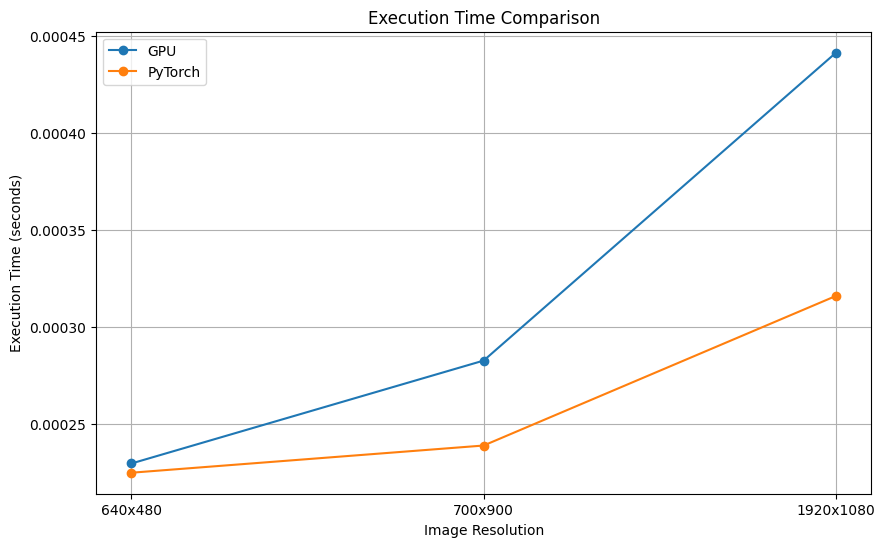

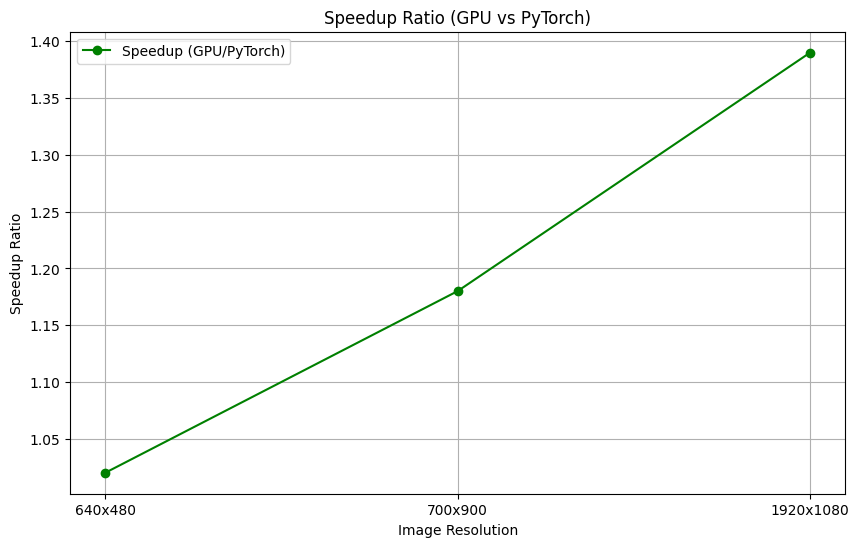

In [11]:
import matplotlib.pyplot as plt

# Data
resolutions = ['640x480', '700x900', '1920x1080']
gpu_times = [0.00022975, 0.00028273, 0.00044120]
pytorch_times = [0.000225, 0.000239, 0.000316]
speedup = [1.02, 1.18, 1.39]

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.plot(resolutions, gpu_times, marker='o', label='GPU')
plt.plot(resolutions, pytorch_times, marker='o', label='PyTorch')
plt.title('Execution Time Comparison')
plt.xlabel('Image Resolution')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the speedup ratios
plt.figure(figsize=(10, 6))
plt.plot(resolutions, speedup, marker='o', color='green', label='Speedup (GPU/PyTorch)')
plt.title('Speedup Ratio (GPU vs PyTorch)')
plt.xlabel('Image Resolution')
plt.ylabel('Speedup Ratio')
plt.legend()
plt.grid(True)
plt.show()


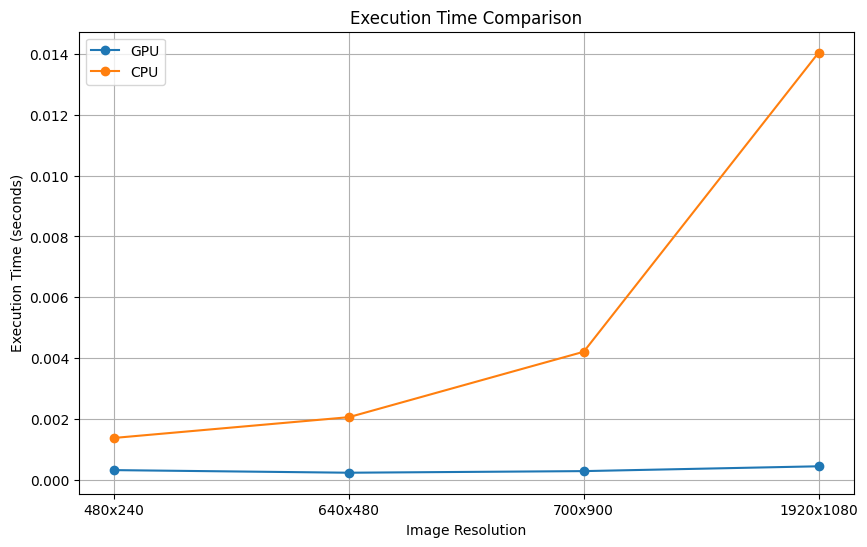

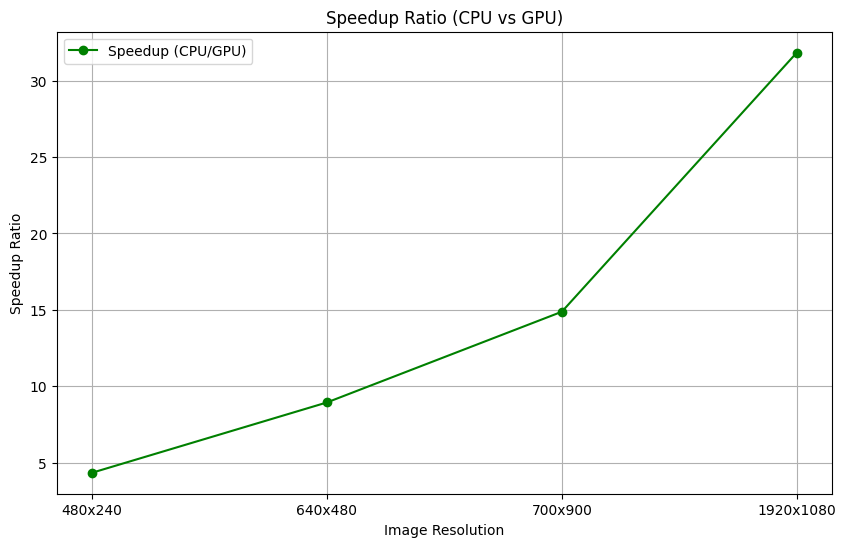

In [12]:
import matplotlib.pyplot as plt

# Data
resolutions = ['480x240', '640x480', '700x900', '1920x1080']
gpu_times = [0.00031553, 0.00022975, 0.00028273, 0.00044120]
cpu_times = [0.00137312, 0.00205611, 0.00420714, 0.0140391]
speedup = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.plot(resolutions, gpu_times, marker='o', label='GPU')
plt.plot(resolutions, cpu_times, marker='o', label='CPU')
plt.title('Execution Time Comparison')
plt.xlabel('Image Resolution')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the speedup ratios
plt.figure(figsize=(10, 6))
plt.plot(resolutions, speedup, marker='o', color='green', label='Speedup (CPU/GPU)')
plt.title('Speedup Ratio (CPU vs GPU)')
plt.xlabel('Image Resolution')
plt.ylabel('Speedup Ratio')
plt.legend()
plt.grid(True)
plt.show()
